In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pickle

In [2]:
FIBER = 'Draka-GRIN'
DATA_PATH = Path("../Data") / FIBER
# path to save images
IMAGE_FOLDER = Path("../images") / FIBER
os.makedirs(IMAGE_FOLDER, exist_ok=True)


def file_path(file_name):
    return os.path.join(DATA_PATH, file_name)


def image_path(file_name):
    return os.path.join(IMAGE_FOLDER, file_name)


In [3]:
REF_SIZE = 24
TICK_SIZE = REF_SIZE
LEGEND_SIZE = REF_SIZE - 4
LABEL_SIZE = REF_SIZE + 2
TITLE_SIZE = REF_SIZE + 2
SMALL_TITLE_SIZE = REF_SIZE
TINY_TITLE_SIZE = REF_SIZE - 4
SUP_TITLE_SIZE = REF_SIZE + 6
FIGSIZE = (8, 5)
SAVE_FIG = True

In [4]:
DATA_FILE = DATA_PATH / "processed_data.pkl"
qs = (0, 1, 2, 3)
deformations2show = [0,2,3,4]

#load pickle
with open(DATA_FILE, 'rb') as f:
    data = pickle.load(f)

In [5]:
# load parameters associated with the shrinked data files
with open(file_path("param_small.pkl"), "rb") as file:
    param = pickle.load(file, encoding="latin1")

# deformation values
Delta_x = param["Delta_x"]

## $\Gamma_q$ as a function of the deformation

The values of $\Gamma_q$ are found by fitting the theoretical prediction 
(Eq.4 of the main text) 
to the experimental data.
They represent the azimuthal perturbation of the refractive index $\sum_q \Gamma_q\cos(q\phi)$



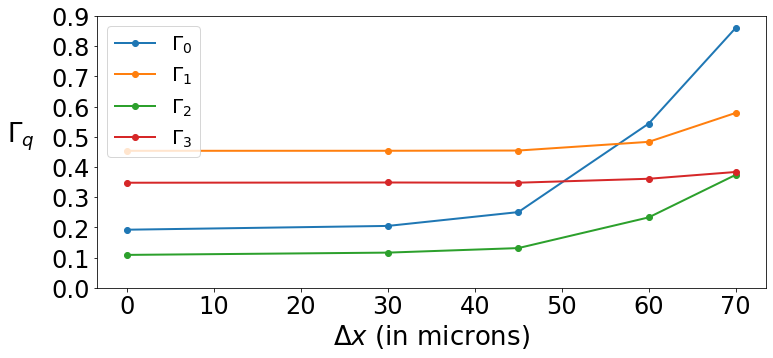

In [7]:
gammas = data['theo']['gammas']

plt.figure(figsize = (12,5))
for ind_q, q in enumerate(qs):
    plt.plot(
        Delta_x, 
        gammas[:,ind_q], 
        marker = 'o',
        label = rf'$\Gamma_{q}$',
        linewidth = 2,
    )
plt.legend()
plt.ylabel(r'$\Gamma_q$', fontsize=LABEL_SIZE, labelpad=30, rotation=0)
plt.xlabel(r"$\Delta x$ (in microns)", fontsize=LABEL_SIZE)
plt.xticks(fontsize=TICK_SIZE)
plt.yticks(fontsize=TICK_SIZE)
plt.legend(fontsize=LEGEND_SIZE, loc = 'upper left')
plt.ylim([0.,0.9])

if SAVE_FIG:
    plt.savefig(
        image_path(f"Gamma_q.svg"),
        dpi=300,
    )
